In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'company-bankruptcy-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1111894%2F1938459%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241006%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241006T050556Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D93a0c0e46be282255a91c54b8acf86ba6b84e4f917426f7053f83115d9a49be9b0d9b36ad6223eca34ff0fc6adc7239564db4add0591d82e339777585eab89c641e383aed71d503061d579230ce0929a8f0381fe37817614945de718a7b244cf808828d43fcefa582137b59c27f581b4b7dbb276868e032354357f066c5c5cfec02baad7aa51f7a341d9cdee3bc9b78c51b168e7fb7d475224cf9a08ff9b514a91c3d53115ae7231b73ab798e31192ac69b730befd30d985884cc9f3fbadc86c8621d517812604c0cc6a68c1303fbd483c9f529be9ebd38f62bf43900a2b02a33bd71c0ccb8c856c667e449573851adc2910bce4ee731af87d878b8d437ec39c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


## Attribute Information:

There are total 95 features. This Dataset has a lot of features. The Dataset description is given on the Data's page itself.
Before blindly performing EDA it's important to have information about the data.

https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction

First we will train the model on raw data, and we will use <b> Feature Selection </b> technique to highlight some of the features and train on selected features. Hence, we will compare the models and accuracy.


## Our Plan



- <b> 1. Observe Dataset </b>


- <b> 2. Exploratory Data Analysis </b>

    - 2.1 Datset Cleaning
    - 2.2 Check for data imbalance
    


- <b> 3. Data Preprocessing </b>

    - 3.2 Split Training and testing
    - 3.2 Feature Selection with RandomForest
    - 3.3 PCA
    
    
- <b> 4. Models, Hyperparameter Tuning, Cross Validation and Model Evaluation </b>

    - 4.1 Logistic Regression
    - 4.2 Naive Bayes
    - 4.3 K-Nearest Neighbor
    - 4.4 Decision Tree
    - 4.5 Random Forest
    - 4.6 XGBoost
    


# 1. Observe Dataset

In [ ]:
import pandas as pd
pd.set_option('max_columns', None)

In [ ]:
path = "../input/company-bankruptcy-prediction/"

In [ ]:
df = pd.read_csv(path + 'data.csv')

In [ ]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.0068

In [ ]:
df.shape

(6819, 96)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
corr = df.corr()

<AxesSubplot:>

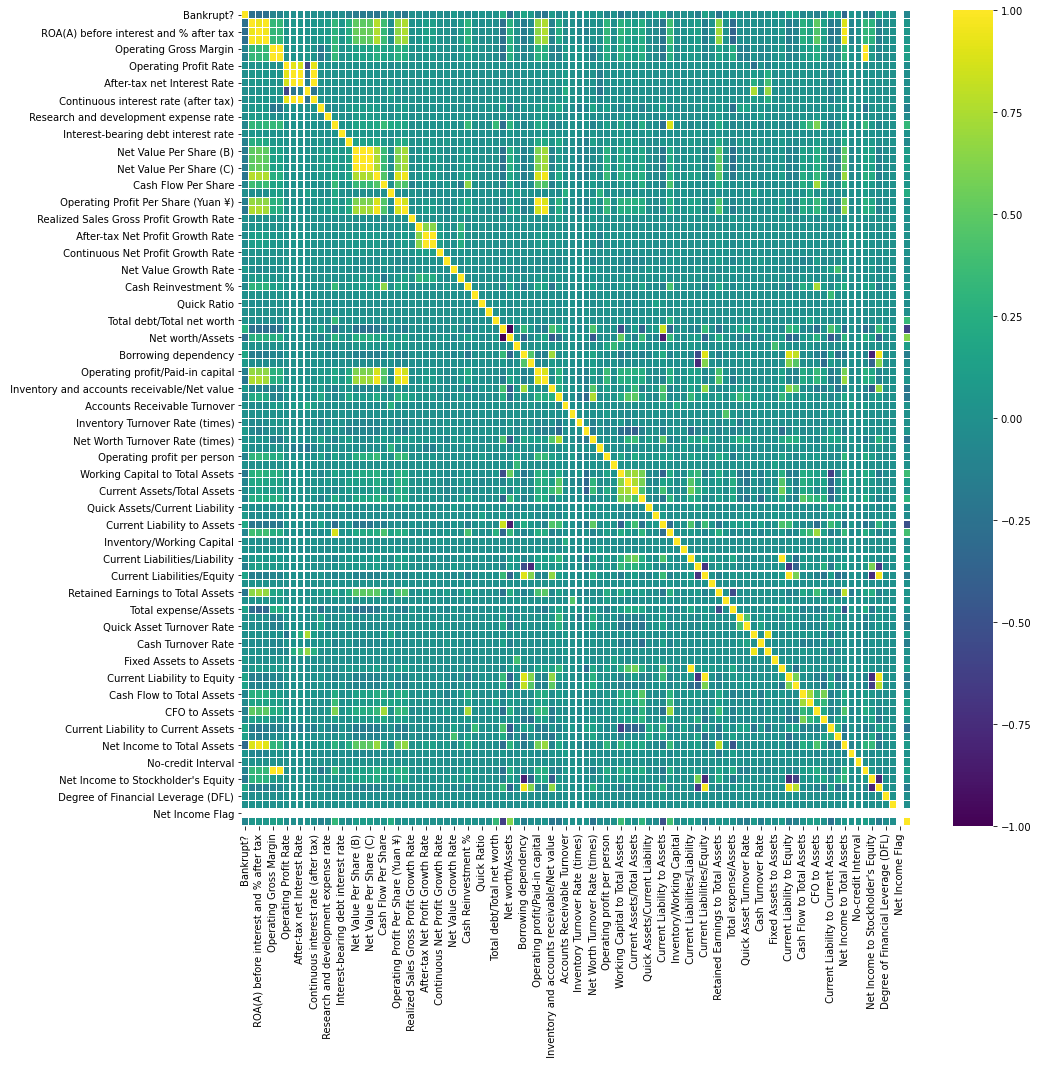

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr, ax = ax, cmap = 'viridis', linewidth = 0.1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

### Observation

- All the features are numerical (int64 or float64)
- All the values are scaled between -1 to 1.

# Exploratory Data Analysis

- 2.1 Checking for data imbalance
- 2.2 Outliers
- 2.3 Filling null values


### 2.1 Checking for Data imbalance

In [ ]:
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

In [ ]:
print('Financially stable:', round(df['Bankrupt?'].value_counts()[0] / len(df) * 100,2) ,'%')
print('Financially unstable:', round(df['Bankrupt?'].value_counts()[1] / len(df) * 100, 2), '%')

Financially stable: 96.77 %
Financially unstable: 3.23 %


We see the data is highly skewed towards, Financially stable. If we train the model on this dataset, our prediction will be biased towards Financially stabled.

We will balance the dataset, to train our model.

Notice: Notice how imbalanced is our original dataset! Most of the comapnies are Financially Stable. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most of the companies are Financially Stable. But we don't want our model to assume, we want our model to detect patterns that give signs of Bankrupt!

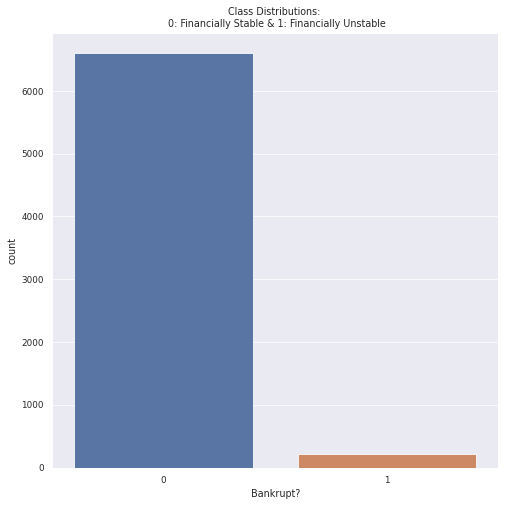

In [ ]:
## Visualizing the datas

sns.set_theme(context = 'paper')


plt.figure(figsize = (8,8))
sns.countplot(x = 'Bankrupt?', data = df);
plt.title('Class Distributions: \n 0: Financially Stable & 1: Financially Unstable');

#### Splitting the Data (Original DataFrame)


Before proceeding with the <b> RandomUnderSampling </b> technique we have to seperate the original dataframe.

<b>Why? </b>

for testing purposes, remeber although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques. The main goal is to fit the model with the dataframes that were undersample and oversample (in order for our model to detect the patterns) and test it on the original testing set.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold

print("Financially Stable:", round(df['Bankrupt?'].value_counts()[0] / len(df) * 100, 2), '% of the dataset')
print("Financially Unstable:", round(df['Bankrupt?'].value_counts()[1] / len(df) * 100,2),'% of the dataset')

X = df.drop('Bankrupt?', axis = 1)
y = df['Bankrupt?']

sss = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False)

for train_index, test_index in sss.split(X,y):
    print("\n Train", train_index, "Test", test_index)
    org_Xtrain, org_Xtest = X.iloc[train_index], X.iloc[test_index]
    org_ytrain, org_ytest = y.iloc[train_index], y.iloc[test_index]


Financially Stable: 96.77 % of the dataset
Financially Unstable: 3.23 % of the dataset

 Train [1104 1118 1132 ... 6816 6817 6818] Test [   0    1    2 ... 1383 1384 1385]

 Train [   0    1    2 ... 6816 6817 6818] Test [1104 1118 1132 ... 2796 2797 2798]

 Train [   0    1    2 ... 6816 6817 6818] Test [1860 1861 1862 ... 4136 4137 4138]

 Train [   0    1    2 ... 6816 6817 6818] Test [2100 2147 2148 ... 5475 5476 5477]

 Train [   0    1    2 ... 5475 5476 5477] Test [3749 3908 4071 ... 6816 6817 6818]


In [ ]:
import numpy as np

In [ ]:
## turn into an array

org_Xtrain = org_Xtrain.values
org_Xtest = org_Xtest.values
org_ytrain = org_ytrain.values
org_ytest = org_ytest.values

## See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(org_ytrain, return_counts = True)
test_unique_label, test_counts_label = np.unique(org_ytest, return_counts = True)

print('Label Distirubtions: \n')
print(train_counts_label / len(org_ytrain))
print(test_counts_label / len(org_ytest))

Label Distirubtions: 

[0.96774194 0.03225806]
[0.96771827 0.03228173]


#### Random Under-Sampling and OverSampling

In this phase of the project we will implement "Random Under Sampling" which basically consists of removing data in order to have a more balanced dataset and this avoiding our models to overfitting.


In [ ]:
## Lets shuffle the data before creating the subsamples

xdf = df.sample(frac = 1)

## amount of Financially unstable data is 220
# sdf = Financially stable
# ndf = Financially unstable

sdf = df.loc[xdf['Bankrupt?'] == 0][:220]
ndf = df.loc[xdf['Bankrupt?']==1]

normal_distributed_df = pd.concat([sdf, ndf])

# Shuffling again

nxdf = normal_distributed_df.sample(frac = 1, random_state = 42)

In [ ]:
nxdf.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
1118,1,0.390825,0.489806,0.435676,0.596340,0.596340,0.998950,0.796742,0.808702,0.302432,0.780428,6.260000e+09,2.040000e+08,0.462166,0.000696,0.000000,0.158780,0.158780,0.158780,0.185119,0.318597,0.005793,0.094943,0.156587,0.022005,0.847895,0.686728,0.686728,0.216659,5.260000e+08,0.000410,0.263177,0.378497,0.006797,0.002608,0.629176,0.009900,0.153974,0.846026,0.006763,0.379525,0.011952,0.094900,0.155622,0.395220,0.031484,0.001451,0.004357,1.217135e-04,2.345143e-04,0.016129,0.026764,0.391013,0.014491,0.765001,0.421241,0.431256,0.119648,0.006486,0.005380,0.117798,0.342360,0.277236,0.001158,0.725576,0.733161,0.332649,0.004314,0.901144,0.002089,0.041343,5.166511e-04,5.118275e-04,0.593959,3.765960e-04,0.671639,0.075057,0.725576,0.332649,0.114596,0.670312,0.463812,0.573093,0.319879,0.042490,0,0.761755,0.065664,0.624227,0.596339,0.836744,0.281959,0.026451,0.562771,1,0.023534
91,0,0.521620,0.575938,0.566893,0.620454,0.620454,0.999115,0.797534,0.809419,0.303470,0.781680,2.840032e-04,9.850000e+08,0.474952,0.000131,0.229983,0.179049,0.179049,0.179049,0.228893,0.327403,0.028117,0.115463,0.185509,0.022110,0.848080,0.689659,0.689659,0.217632,6.540000e+09,0.000453,0.264266,0.387132,0.012789,0.007298,0.630719,0.004976,0.104181,0.895819,0.005790,0.373317,0.006293,0.115329,0.184436,0.400280,0.140930,0.001136,0.005561,7.640000e+09,

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Bankrupt?, dtype: float64


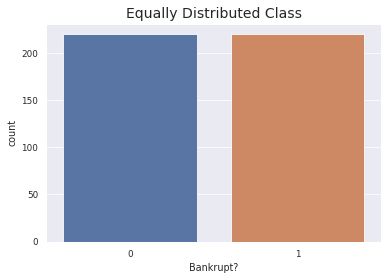

In [ ]:
## Checking new dataframe

print("Distribution of the Classes in the subsample dataset")
print(nxdf['Bankrupt?'].value_counts() / len(nxdf))

sns.countplot('Bankrupt?', data = nxdf)
plt.title("Equally Distributed Class", fontsize = 14)
plt.show()

#### Correlation Matrices

Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample) in order for use to see which features have a high positive or negative correlation with regards to fraud transactions.

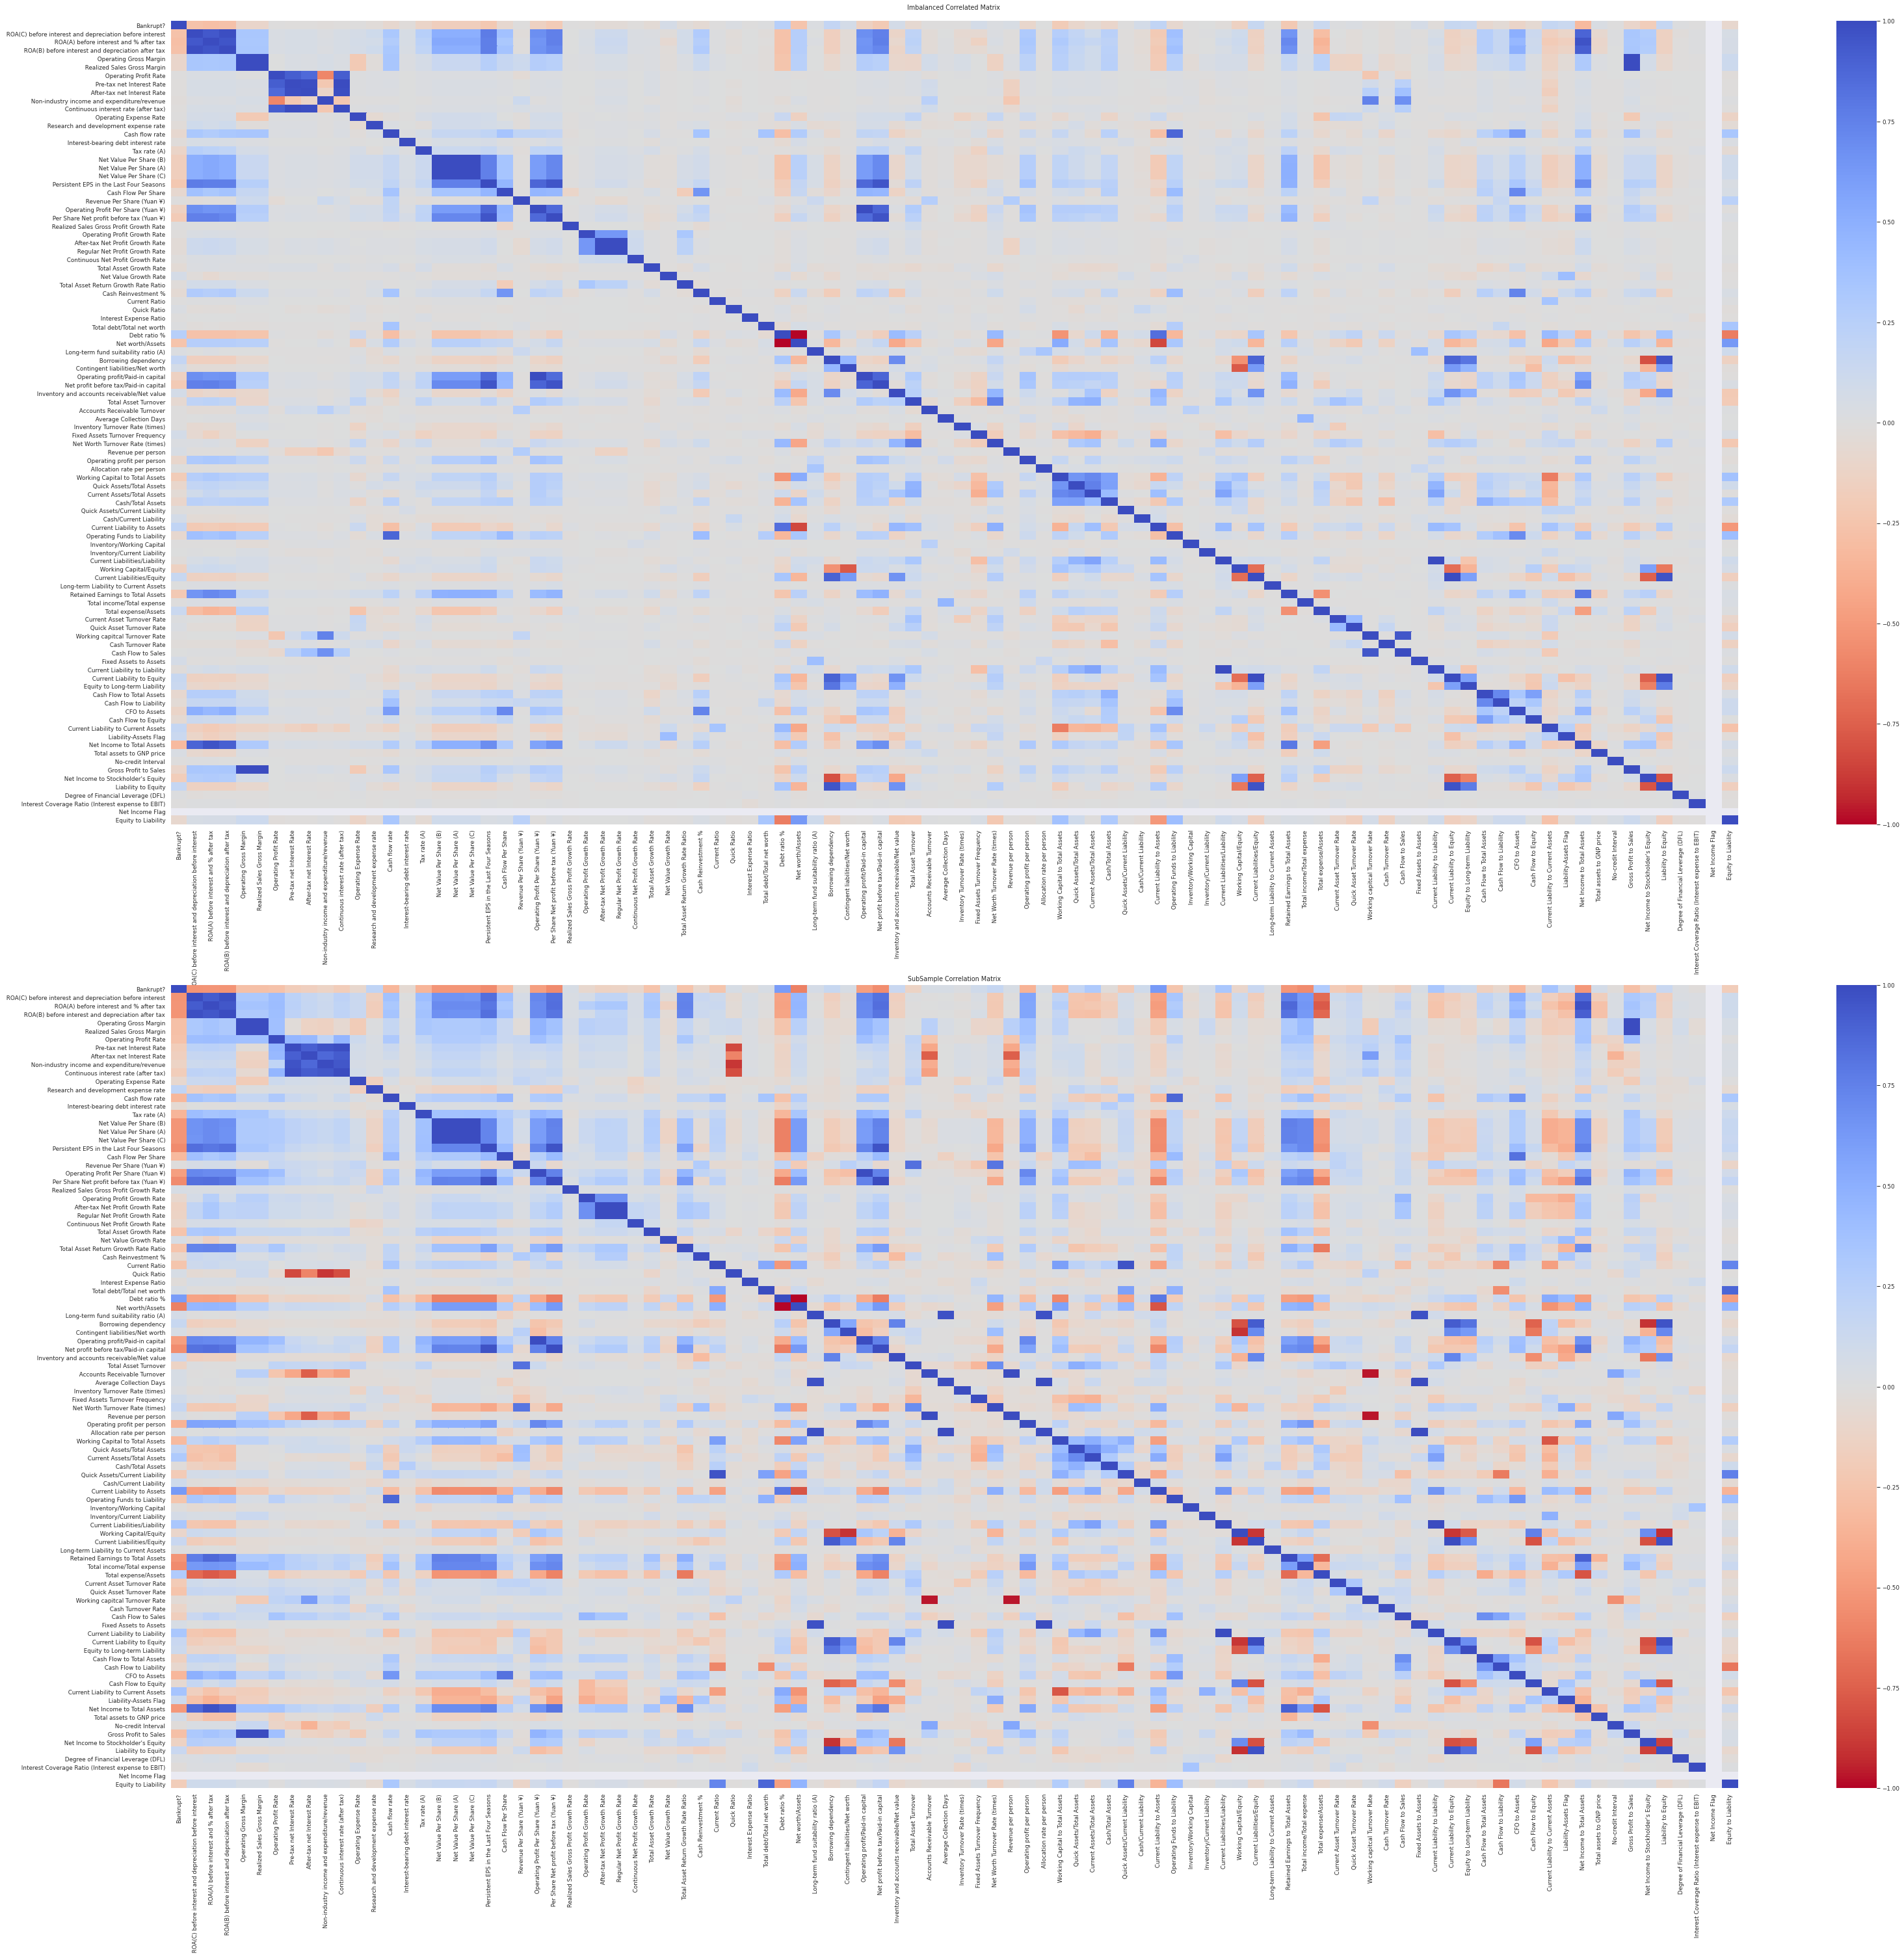

In [ ]:
## make sure we use the subsampe in our correlation

f, (ax1, ax2) = plt.subplots(2,1, figsize = (54,50))

## Entire data frame

corr = df.corr()
sns.heatmap(corr, cmap = 'coolwarm_r', annot_kws = {'size': 20}, ax= ax1)
ax1.set_title("Imbalanced Correlated Matrix \n")


sub_sample_corr = nxdf.corr()
sns.heatmap(sub_sample_corr, cmap = 'coolwarm_r', annot_kws = {'size': 20}, ax = ax2)
ax2.set_title("SubSample Correlation Matrix")
plt.show()

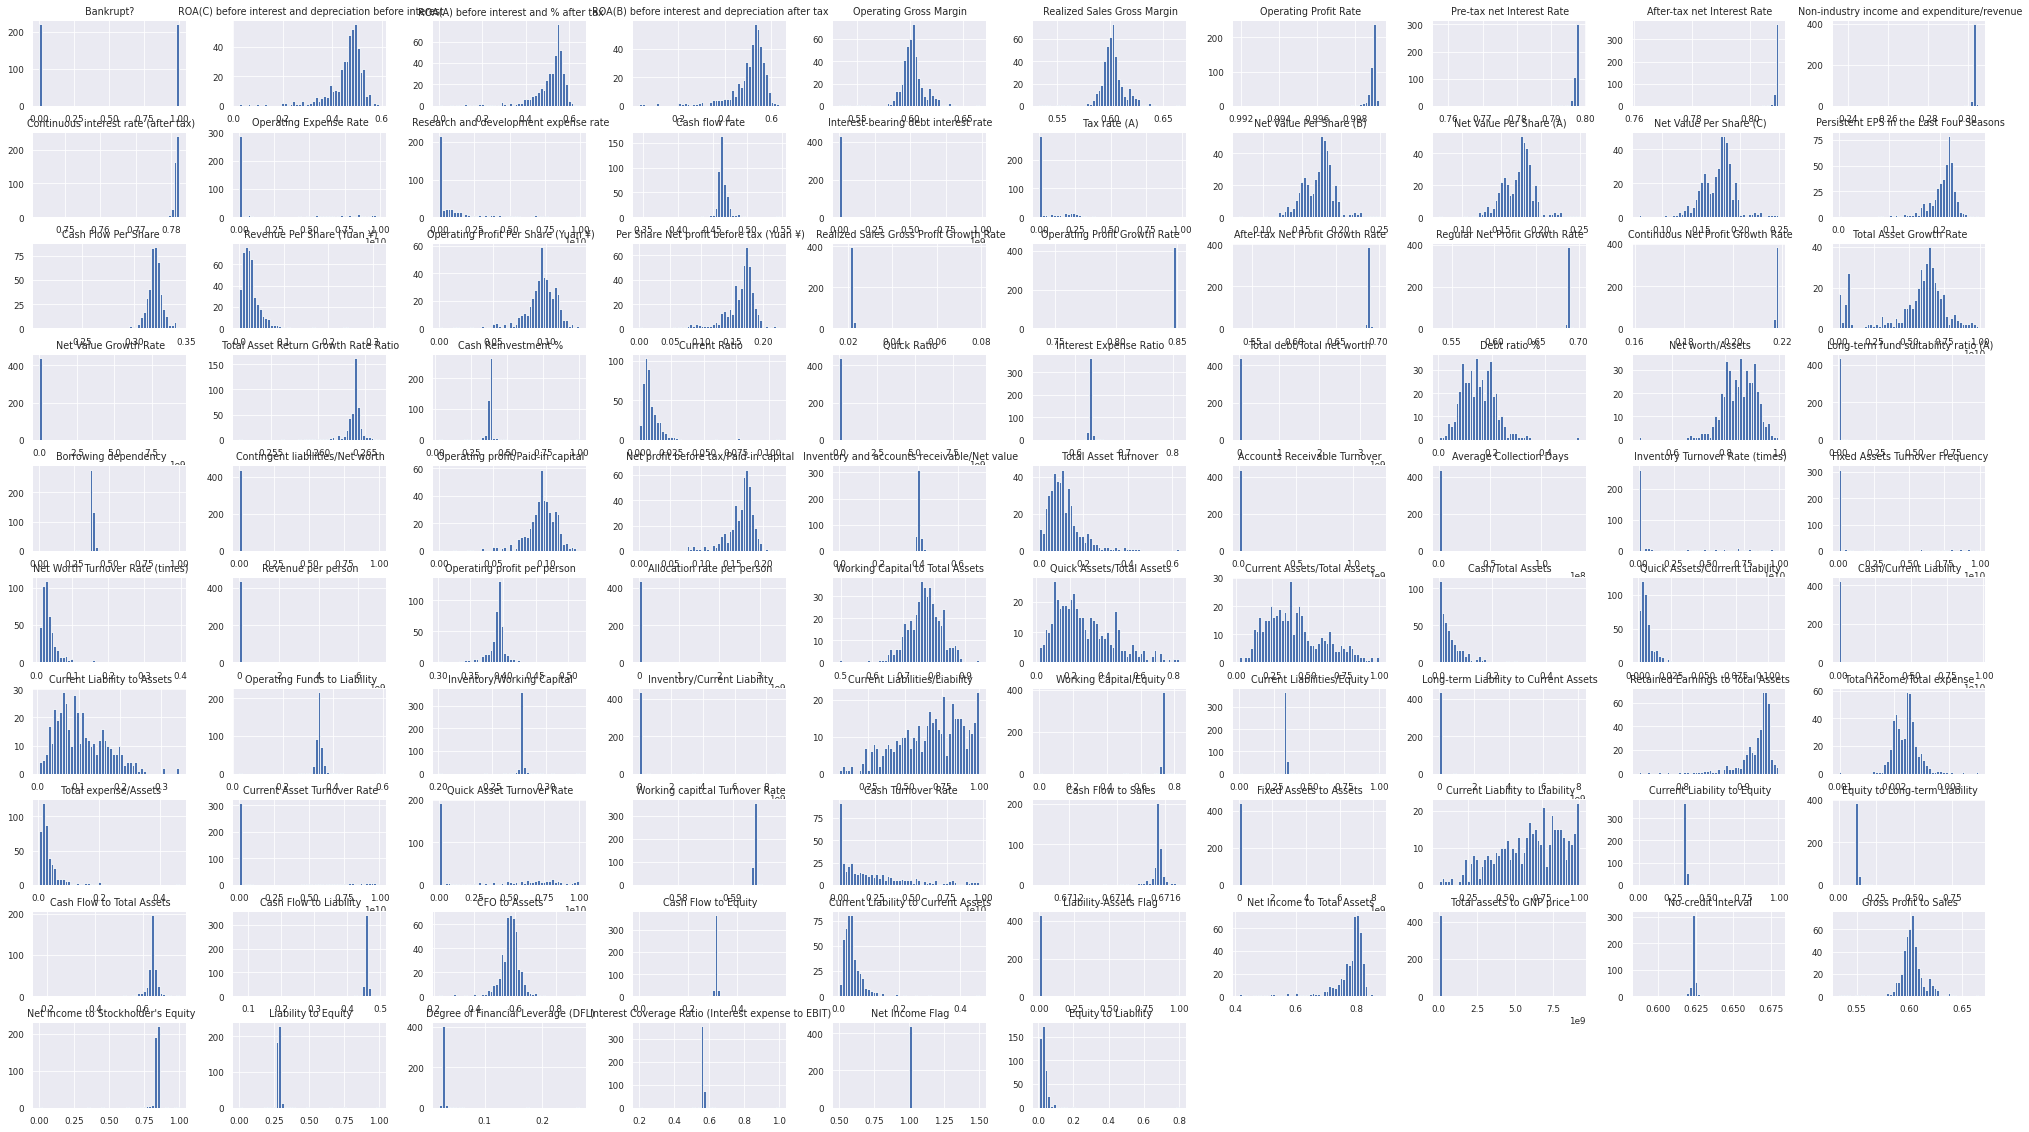

In [ ]:
nxdf.hist(bins = 50, figsize = (35,20))
plt.show()

We can see there are large number of blue square boxes and red square boxes which indicates, those column are has high or low correlation with one or other. So we will use PCA (Dimensionality Reduction) technqiue.

<b> PCA vs Feature Selection? </b>

https://stackoverflow.com/questions/16249625/difference-between-pca-principal-component-analysis-and-feature-selection#:~:text=The%20difference%20is%20that%20PCA,takes%20the%20target%20into%20consideration.&text=PCA%20is%20based%20on%20extracting,data%20shows%20the%20highest%20variability.

Just to add to the very good answers above. The difference is that PCA will try to reduce dimensionality by exploring how one feature of the data is expressed in terms of the other features(linear dependecy). Feature selection instead, takes the target into consideration. It will rank your input variables in terms of how useful they are to predict the target value. This is true for univariate feature selection. Multi variate feature selection can also do something that can be considered a form of PCA, in the sense that it will discard some of the features in the input. But don't take this analogy too far.

## 3. Data Preprocessing

- Split Training and Testing
- Feature selection with RandomForest
- PCA

#### Split Training and Testing

In [ ]:
## this is equally sampled dataset (perfectly balanced target)

X = nxdf.drop(['Bankrupt?'],1)
y = nxdf['Bankrupt?']

rf_fs_Xtrain, rf_fs_Xtest, rf_fs_ytrain, rf_fs_ytest = train_test_split(X,y, test_size = 0.1, random_state = 1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

### Feature selection with RandomForest

In [ ]:
## modelling with balanced traget

model = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
model.fit(rf_fs_Xtrain, rf_fs_ytrain)

sel = SelectFromModel(model)

In [ ]:
## balanced target

sel.fit(rf_fs_Xtrain, rf_fs_ytrain)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                                 random_state=0))

In [ ]:
# balanced

selected_feat= rf_fs_Xtrain.columns[(sel.get_support())]
len(selected_feat)

28

In [ ]:
selected_feat

Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Pre-tax net Interest Rate', ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Net Value Per Share (B)',
       ' Net Value Per Share (A)', ' Persistent EPS in the Last Four Seasons',
       ' Per Share Net profit before tax (Yuan ¥)', ' Net Value Growth Rate',
       ' Total debt/Total net worth', ' Debt ratio %', ' Net worth/Assets',
       ' Borrowing dependency', ' Net profit before tax/Paid-in capital',
       ' Accounts Receivable Turnover', ' Average Collection Days',
       ' Current Liability to Assets', ' Current Liabilities/Equity',
       ' Retained Earnings to Total Assets', ' Total income/Total expense',
       ' Current Liability to Equity', ' Net Income to Total Assets',
       ' Net Income to Stockhol

In [ ]:
## Creating a dataframe for only selected values to train later

rf_fs = pd.DataFrame()

for column in selected_feat:
    if column in nxdf:
        rf_fs[column] = nxdf[column].values



In [ ]:
rf_fs

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Net Value Per Share (B),Net Value Per Share (A),Persistent EPS in the Last Four Seasons,Per Share Net profit before tax (Yuan ¥),Net Value Growth Rate,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Borrowing dependency,Net profit before tax/Paid-in capital,Accounts Receivable Turnover,Average Collection Days,Current Liability to Assets,Current Liabilities/Equity,Retained Earnings to Total Assets,Total income/Total expense,Current Liability to Equity,Net Income to Total Assets,Net Income to Stockholder's Equity,Liability to Equity,Equity to Liability
0,0.390825,0.489806,0.435676,0.796742,0.808702,0.302432,0.780428,0.158780,0.158780,0.185119,0.156587,0.000410,0.009900,0.153974,0.846026,0.379525,0.155622,0.001451,0.004357,0.117798,0.332649,0.901144,0.002089,0.332649,0.761755,0.836744,0.281959,0.023534
1,0.521620,0.575938,0.566893,0.797534,0.809419,0.303470,0.781680,0.179049,0.179049,0.228893,0.185509,0.000453,0.004976,0.104181,0.895819,0.373317,0.184436,0.001136,0.005561,0.053069,0.328344,0.937257,0.002316,0.328344,0.821701,0.841885,0.278388,0.036346
2,0.494418,0.567815,0.549976,0.797623,0.809537,0.303511,0.781813,0.192069,0.192069,0.252529,0.198765,0.000480,0.032250,0.231490,0.768510,0.404567,0.197647,0.000937,0.006740,0.237500,0.354443,0.937312,0.002820,0.354443,0.813856,0.843782,0.298168,0.014353
3,0.491396,0.535325,0.533487,0.797368,0.809277,0.303356,0.781534,0.188572,0.188572,0.210740,0.169165,0.000438,0.011887,0.167518,0.832482,0.378850,0.167702,0.001286,0.004917,0.121096,0.333521,0.929930,0.002202,0.333521,0.792092,0.839630,0.283400,0.021335
4,0.491201,0.542085,0.549601,0.797391,0.809336,0.303997,0.781583,0.176815,0.176815,0.215846,0.170596,0.000494,0.009032,0.147142,0.852858,0.376470,0.169550,0.000651,0.009703,0.135827,0.333298,0.930599,0.002259,0.333298,0.799124,0.840333,0.281329,0.024794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,0.450397,0.504034,0.506986,0.797293,0.809239,0.303489,0.781491,0.178754,0.178754,0.204879,0.160729,0.000426,0.005869,0.115609,0.884391,0.372958,0.159716,0.002141,0.002954,0.050257,0.328359,0.927051,0.002077,0.328359,0.780554,0.838869,0.279036,0.032464
436,0.441184,0.498092,0.488677,0.797123,0.809048,0.303185,0.781286,0.172348,0.172348,0.193533,0.154327,0.000404,0.012833,0.173081,0.826919,0.384412,0.153299,0.001530,0.004132,0.128870,0.334342,0.923034,0.001982,0.334342,0.769694,0.837122,0.284086,0.020525
437,0.470482,0.531127,0.523529,0.797297,0.809229,0.303346,0.781528,0.163457,0.163457,0.212537,0.166453,0.000420,0.015311,0.185688,0.814312,0.384443,0.165455,0.001019,0.006204,0.191836,0.339689,0.928536,0.002169,0.339689,0.789876,0.839290,0.285883,0.018873
438,0.418515,0.433984,0.461427,0.796902,0.808857,0.302892,0.781254,0.139354,0.139354,0.197977,0.149507,0.000333,0.024639,0.216555,0.783445,0.389886,0.148481,0.000870,0.007267,0.211979,0.346780,0.873937,0.002082,0.346780,0.725750,0.828067,0.292648,0.015620


### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
n_components = 2
pca = PCA(n_components = n_components)
pca.fit(nxdf)

PCA(n_components=2)

In [ ]:
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(rf_fs_Xtrain.values)

In [ ]:
x_pca = pca.transform(nxdf)

In [ ]:
x_pca.shape

(440, 2)

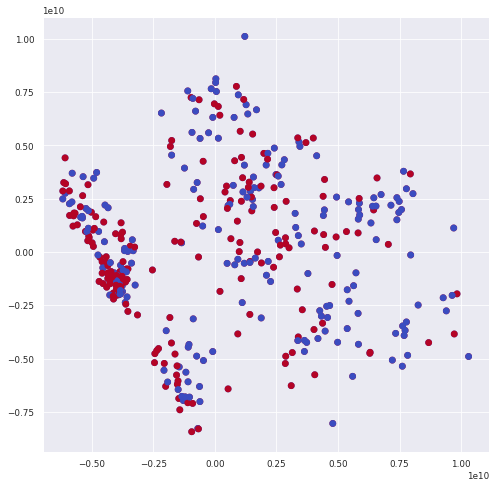

In [ ]:
# PCA scatter plot
plt.figure(figsize = (8,8))
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(rf_fs_ytrain == 0), cmap='coolwarm', label= 'Stable_Company', linewidths=2)
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(rf_fs_ytrain == 1), cmap='coolwarm', label= 'Unstable_Company', linewidths=2)
plt.show()

## Testing our Models

We will test our all the dataset (i.e normal, random forest feature selection and PCA dataset with each model.

For comparison we will make a new dataFrame, and comapre which method performed better

Also as it is classification problem, we will test it with following algorithms

- Logistic Regression
- Naive Bayes
- KNN
- Decision Trees
- Random Forest
- SVM

#### Preparing all the dataset for the models

- <b> nxdf </b> is the original dataset.
- <b> rf_fs </b> is the dataset with Feature Selection from Random Forest


In [ ]:
## Splitting dataset for Normal data without feature selection

X_train, X_test, y_train, y_test = train_test_split(nxdf.drop('Bankrupt?', axis = 1), nxdf['Bankrupt?'],test_size = 0.1, random_state = 1)

In [ ]:
nxdf.shape

(440, 96)

In [ ]:
rf_fs.shape

(440, 28)

- Since <b> rf_fs </b> target feature <b> Bankrupt? </b> has already been dropped. We know nxdf and rf_fs has same target value i.e ['Bankrupt'] so we will use the target value from nxdf for splitting Selected Dataset

In [ ]:
## Splitting RandomForest Feature Selection dataset

fs_Xtrain, fs_Xtest, fs_ytrain, fs_ytest = train_test_split(rf_fs, nxdf['Bankrupt?'], test_size = 0.1, random_state = 1)

In [ ]:
model_score = pd.DataFrame(columns = ("Original_Dataset","Selected_Dataset"))

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_score, recall_score, confusion_matrix

### Original Dataset

In [ ]:
lrmodel1 = LogisticRegression(max_iter = 1000)
lrmodel1.fit(X_train, y_train)
score1 = lrmodel1.score(X_test, y_test)
lr_pred1 = lrmodel1.predict(X_test)

In [ ]:
## Accuracy on Original Datset without Feature Selection:

print("Score:", score1)

Score: 0.7045454545454546


In [ ]:
lr_cm1 = confusion_matrix(y_test, lr_pred1, labels = (1,0))

In [ ]:
lr_cm1

array([[12,  9],
       [ 4, 19]])

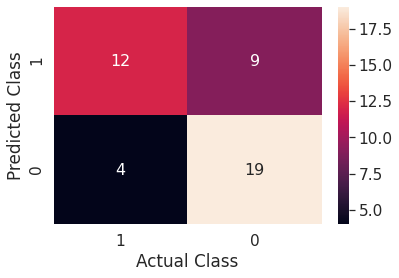

In [ ]:
x_axis_labels = [1,0]
y_axis_labels = [1,0]

sns.set(font_scale=1.4)
sns.heatmap(lr_cm1, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, annot_kws = {'size': 16})
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

In [ ]:
y_test.value_counts()

0    23
1    21
Name: Bankrupt?, dtype: int64

### Feature Selection Dataset

In [ ]:
lrmodel2 = LogisticRegression(max_iter = 1000)
lrmodel2.fit(fs_Xtrain, fs_ytrain)
score2 = lrmodel2.score(fs_Xtest, fs_ytest)
lr_ypred2 = lrmodel2.predict(fs_Xtest)

In [ ]:
print("Score", score2)

Score 0.5909090909090909


In [ ]:
lr_cm2 = confusion_matrix(fs_ytest, lr_ypred2, labels = (1,0))
print("Confusion Matrix: \n", lr_cm2)

Confusion Matrix: 
 [[ 3 18]
 [ 0 23]]


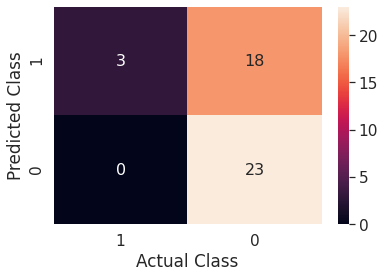

In [ ]:
x_axis_labels = [1,0]
y_axis_labels = [1,0]

sns.set(font_scale=1.4)
sns.heatmap(lr_cm2, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, annot_kws = {'size': 16})
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

In [ ]:
model_score = model_score.append(pd.DataFrame({'Original_Dataset':[score1], 'Selected_Dataset': [score2]}, index = ['LogisticRegression']))

In [ ]:
model_score

,Original_Dataset,Selected_Dataset
LogisticRegression,0.704545,0.590909


# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

### Original dataset

In [ ]:
naiveb1 = GaussianNB()

In [ ]:
naiveb1.fit(X_train, y_train)
score1 = naiveb1.score(X_test, y_test)
nb_pred1 = naiveb1.predict(X_test)

In [ ]:
print("Score:", score1)

Score: 0.5227272727272727


In [ ]:
nb_cm1 = confusion_matrix(y_test, nb_pred1, labels = (1,0))

In [ ]:
print("Confusion Matrix: \n", nb_cm1)

Confusion Matrix: 
 [[ 0 21]
 [ 0 23]]


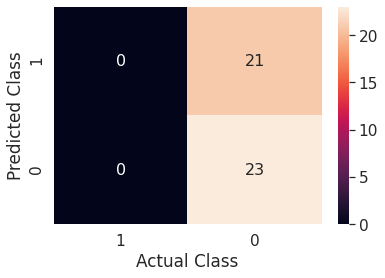

In [ ]:
x_axis_labels = [1,0]
y_axis_labels = [1,0]

sns.set(font_scale=1.4)
sns.heatmap(nb_cm1, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, annot_kws = {'size': 16})
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

### Feature Selection Dataset

In [ ]:
naiveb2 = GaussianNB()

In [ ]:
naiveb2.fit(fs_Xtrain, fs_ytrain)
score2 = naiveb2.score(fs_Xtest, fs_ytest)
nb_pred2 = naiveb2.predict(fs_Xtest)

In [ ]:
print("Score:", score2)

Score: 0.5227272727272727


In [ ]:
nb_cm2 = confusion_matrix(fs_ytest, nb_pred2, labels = [1,0])
print("Confusion Matrix: \n", nb_cm2)

Confusion Matrix: 
 [[ 0 21]
 [ 0 23]]


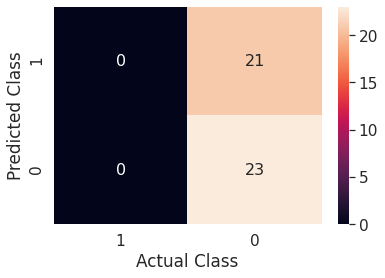

In [ ]:
x_axis_labels = [1,0]
y_axis_labels = [1,0]

sns.set(font_scale=1.4)
sns.heatmap(nb_cm2, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, annot_kws = {'size': 16})
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

In [ ]:
model_score = model_score.append(pd.DataFrame({'Original_Dataset': [score1], 'Selected_Dataset': [score2]}, index = ['NaiveBayes']))

In [ ]:
model_score

,Original_Dataset,Selected_Dataset
LogisticRegression,0.704545,0.590909
NaiveBayes,0.522727,0.522727


# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

### Original Dataset

In [ ]:
knn1 = KNeighborsClassifier(n_neighbors = 7)

In [ ]:
knn1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [ ]:
score1 = knn1.score(X_test, y_test)
print(score1)

0.75


In [ ]:
knn_pred1 = knn1.predict(X_test)
knn_cm1 = confusion_matrix(y_test, knn_pred1, labels = (1,0))
print("Confusion Matrix:\n", knn_cm1)

Confusion Matrix:
 [[13  8]
 [ 3 20]]


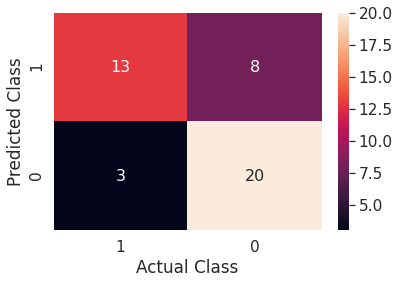

In [ ]:
x_axis_labels = [1,0]
y_axis_labels = [1,0]

sns.set(font_scale=1.4)
sns.heatmap(knn_cm1, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, annot_kws = {'size': 16})
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

In [ ]:
### Hyperparameter tuning for KNN

In [ ]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    pred_knn = knn.predict(X_test)
    error_rate.append(np.mean(pred_knn != y_test))

Text(0, 0.5, 'Error Rate')

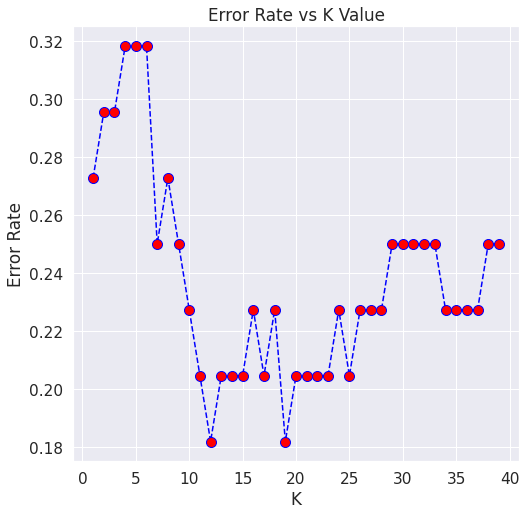

In [ ]:
plt.figure(figsize = (8,8))
plt.plot(range(1,40), error_rate, color = 'blue', linestyle = 'dashed', marker = 'o', markerfacecolor = 'red', markersize = 10);
plt.title('Error Rate vs K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
## let's see how much difference does it makes

tuned_knn1 = KNeighborsClassifier(n_neighbors = 4)
tuned_knn1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [ ]:
tuned_score1 = tuned_knn1.score(X_test, y_test)
print(tuned_score1)

0.6818181818181818


We can see, it's not that different

### Feature Selection Dataset

In [ ]:
knn2 = KNeighborsClassifier(n_neighbors = 7)
knn2.fit(fs_Xtrain, fs_ytrain)

KNeighborsClassifier(n_neighbors=7)

In [ ]:
score2 = knn2.score(fs_Xtest, fs_ytest)
print(score2)

0.8636363636363636


In [ ]:
knn_pred2 = knn2.predict(fs_Xtest)
knn_cm2 = confusion_matrix(fs_ytest, knn_pred2, labels = (1,0))
print("Confusion Matrix: \n", knn_cm2)

Confusion Matrix: 
 [[16  5]
 [ 1 22]]


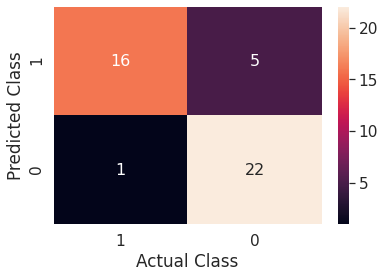

In [ ]:
x_axis_labels = [1,0]
y_axis_labels = [1,0]

sns.set(font_scale=1.4)
sns.heatmap(knn_cm2, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, annot_kws = {'size': 16})
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

In [ ]:
## Hyperparamter tuning for this

In [ ]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(fs_Xtrain, fs_ytrain)
    pred_knn = knn.predict(fs_Xtest)
    error_rate.append(np.mean(pred_knn != fs_ytest))

Text(0, 0.5, 'Error Rate')

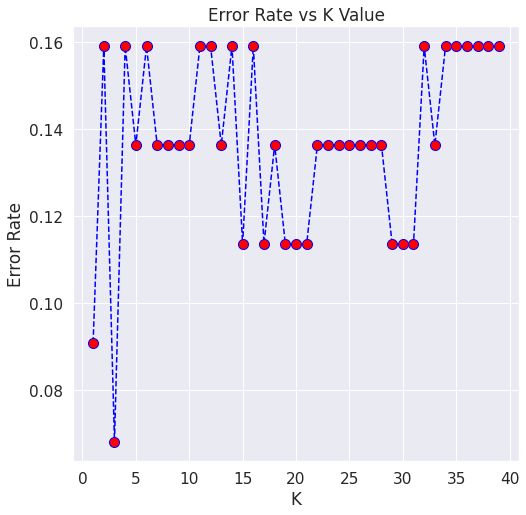

In [ ]:
plt.figure(figsize = (8,8))
plt.plot(range(1,40), error_rate, color = 'blue', linestyle = 'dashed', marker = 'o', markerfacecolor = 'red', markersize = 10);
plt.title('Error Rate vs K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

Let's test with, K = 5

In [ ]:
tuned_knn2 = KNeighborsClassifier(n_neighbors = 14)
tuned_knn2.fit(fs_Xtrain, fs_ytrain)

KNeighborsClassifier(n_neighbors=14)

In [ ]:
tuned_score2 = tuned_knn2.score(fs_Xtest, fs_ytest)
print(tuned_score2)

0.8409090909090909


In [ ]:
tuned_knn_pred2 = knn.predict(fs_Xtest)
tuned_cm2 = confusion_matrix(fs_ytest, tuned_knn_pred2, labels = (1,0))
print("Confusion Matrix: \n", tuned_cm2)

Confusion Matrix: 
 [[16  5]
 [ 2 21]]


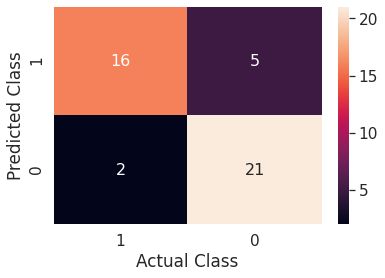

In [ ]:
x_axis_labels = [1,0]
y_axis_labels = [1,0]

sns.set(font_scale=1.4)
sns.heatmap(tuned_cm2, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, annot_kws = {'size': 16})
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

A bit better but not that great

In [ ]:
model_score = model_score.append(pd.DataFrame({'Original_Dataset': [tuned_score1], 'Selected_Dataset': [tuned_score2]}, index = ['KNN']))


In [ ]:
model_score

,Original_Dataset,Selected_Dataset
LogisticRegression,0.704545,0.590909
NaiveBayes,0.522727,0.522727
KNN,0.681818,0.840909


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt1 = DecisionTreeClassifier()

### Original data

In [ ]:
dt1 = dt1.fit(X_train, y_train)

In [ ]:
score1 = dt1.score(X_test, y_test)
print(score1)

0.8636363636363636


In [ ]:
dt_pred1 = dt1.predict(X_test)
dt_cm1 = confusion_matrix(y_test, dt_pred1, labels = [1,0])
print("Confusion Matrix: \n", dt_cm1)

Confusion Matrix: 
 [[18  3]
 [ 3 20]]


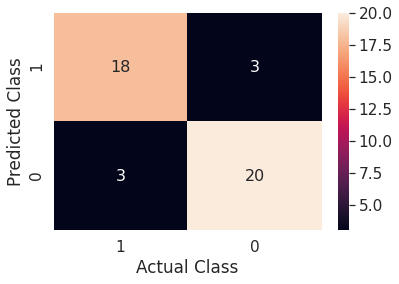

In [ ]:
x_axis_labels = [1,0]
y_axis_labels = [1,0]

sns.set(font_scale=1.4)
sns.heatmap(dt_cm1, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, annot_kws = {'size': 16})
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

### Feature Selection Data

In [ ]:
dt2 = DecisionTreeClassifier()

In [ ]:
dt2 = dt2.fit(fs_Xtrain, fs_ytrain)

In [ ]:
score2 = dt2.score(fs_Xtest, fs_ytest)
print(score2)

0.9090909090909091


In [ ]:
dt_pred2 = dt2.predict(fs_Xtest)
dt_cm2 = confusion_matrix(fs_ytest, dt_pred2, labels = [1,0])
print("Confusion Matrix: \n", dt_cm2)

Confusion Matrix: 
 [[19  2]
 [ 2 21]]


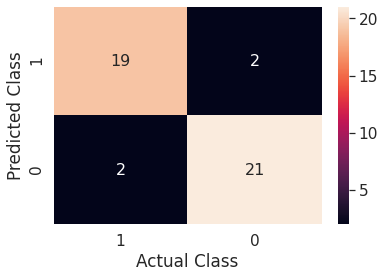

In [ ]:
x_axis_labels = [1,0]
y_axis_labels = [1,0]

sns.set(font_scale=1.4)
sns.heatmap(dt_cm2, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, annot_kws = {'size': 16})
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

In [ ]:
model_score = model_score.append(pd.DataFrame({'Original_Dataset': [score1], 'Selected_Dataset': [score2]}, index = ['DecisionTrees']))


In [ ]:
model_score

,Original_Dataset,Selected_Dataset
LogisticRegression,0.704545,0.590909
NaiveBayes,0.522727,0.522727
KNN,0.681818,0.840909
DecisionTrees,0.863636,0.909091


# Random Forest

In [ ]:
rfclf1 = RandomForestClassifier(n_estimators = 100)

### With Original dataset

In [ ]:
rfclf1.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
score1 = rfclf1.score(X_test, y_test)
print(score1)

0.9090909090909091


In [ ]:
rf_pred1 = rfclf1.predict(X_test)
rf_cm1 = confusion_matrix(y_test, rf_pred1, labels = (1,0))
print("Confusion Matrix: \n", rf_cm1)

Confusion Matrix: 
 [[19  2]
 [ 2 21]]


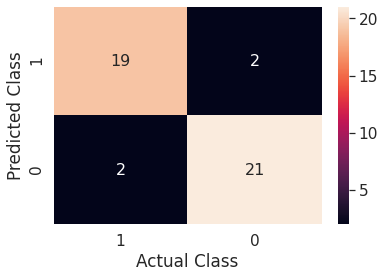

In [ ]:
x_axis_labels = [1,0]
y_axis_labels = [1,0]

sns.set(font_scale=1.4)
sns.heatmap(rf_cm1, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, annot_kws = {'size': 16})
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

### With Selected Features

In [ ]:
rfclf2 = RandomForestClassifier(n_estimators = 100)

In [ ]:
rfclf2.fit(fs_Xtrain, fs_ytrain)

RandomForestClassifier()

In [ ]:
score2 = rfclf2.score(fs_Xtest, fs_ytest)
print(score2)

0.9318181818181818


In [ ]:
rf_pred2 = rfclf2.predict(fs_Xtest)
rf_cm2 = confusion_matrix(fs_ytest, rf_pred2, labels = [1,0])
print("Confusion Matrix: \n", rf_cm2)

Confusion Matrix: 
 [[19  2]
 [ 1 22]]


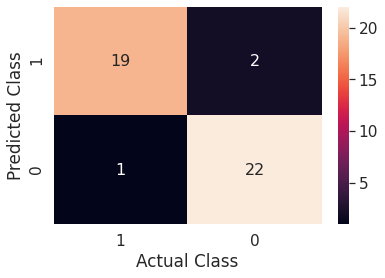

In [ ]:
x_axis_labels = [1,0]
y_axis_labels = [1,0]

sns.set(font_scale=1.4)
sns.heatmap(rf_cm2, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, annot_kws = {'size': 16})
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

#### Hyperparamter Tuning

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)
               ]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [2,4]

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [ ]:
tuned_rf = RandomForestClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = tuned_rf, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)

In [ ]:
rf_Grid.fit(X_train, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=2)

In [ ]:
rf_Grid.best_params_

{'bootstrap': False,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 33}

In [ ]:
print (f'Train Accuracy - : {rf_Grid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_Grid.score(X_test,y_test):.3f}')

Train Accuracy - : 0.965
Test Accuracy - : 0.886


In [ ]:
tuned_score2 = rf_Grid.score(X_test, y_test)
print(tuned_score2)

0.8863636363636364


In [ ]:
model_score = model_score.append(pd.DataFrame({'Original_Dataset': [score1], 'Selected_Dataset': [tuned_score2]}, index = ['RandomForest']))

In [ ]:
model_score

,Original_Dataset,Selected_Dataset
LogisticRegression,0.704545,0.590909
NaiveBayes,0.522727,0.522727
KNN,0.681818,0.840909
DecisionTrees,0.863636,0.909091
RandomForest,0.909091,0.886364


# XGBoost

In [ ]:
from xgboost import XGBClassifier

### With Original Dataset

In [ ]:
xgb1 = XGBClassifier(n_estimators = 100)
xgb1.fit(X_train, y_train)

[05:05:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
score1 = xgb1.score(X_test, y_test)
print(score1)

0.8863636363636364


In [ ]:
xgb_pred1 = xgb1.predict(X_test)
xgb_cm1 = confusion_matrix(y_test, xgb_pred1, labels = [1,0])
print("Confusion Matrix: \n", xgb_cm1)

Confusion Matrix: 
 [[18  3]
 [ 2 21]]


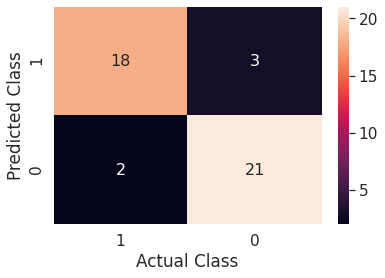

In [ ]:
x_axis_labels = [1,0]
y_axis_labels = [1,0]

sns.set(font_scale=1.4)
sns.heatmap(xgb_cm1, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, annot_kws = {'size': 16})
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

### With Selected Dataset

In [ ]:
xgb2 = XGBClassifier(n_estimators = 100)
xgb2.fit(fs_Xtrain, fs_ytrain)

[05:05:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
score2 = xgb2.score(fs_Xtest, fs_ytest)
print(score2)

0.9090909090909091


In [ ]:
xgb_pred2 = xgb2.predict(fs_Xtest)
xgb_cm2 = confusion_matrix(fs_ytest, xgb_pred2, labels = [1,0])
print("Confusion Matrix: \n", xgb_cm2)

Confusion Matrix: 
 [[18  3]
 [ 1 22]]


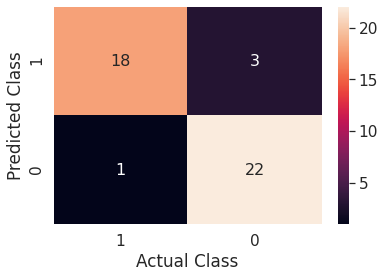

In [ ]:
x_axis_labels = [1,0]
y_axis_labels = [1,0]

sns.set(font_scale=1.4)
sns.heatmap(xgb_cm2, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, annot_kws = {'size': 16})
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

### Hyperparamter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]

}

In [ ]:
tuned_xgb = XGBClassifier()

In [ ]:
random_search = RandomizedSearchCV(tuned_xgb, param_distributions = params, n_iter = 5, scoring = 'roc_auc', n_jobs = 1, cv = 5, verbose = 3)

In [ ]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[05:05:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=12, min_child_weight=3; total time=   0.1s
[05:05:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=12, min_child_weight=3; total time=   0.1s
[05:05:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set e

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=No

In [ ]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
random_search.best_params_

{'min_child_weight': 5,
 'max_depth': 10,
 'learning_rate': 0.05,
 'gamma': 0.4,
 'colsample_bytree': 0.3}

In [ ]:
tuned_score1 = random_search.score(X_test, y_test)
print(tuned_score1)

0.9710144927536232


In [ ]:
print (f'Train Accuracy - : {random_search.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {random_search.score(X_test,y_test):.3f}')

Train Accuracy - : 0.999
Test Accuracy - : 0.971


In [ ]:
tuned_xgb_pred1 = random_search.predict(X_test)
tuned_xgb_cm1 = confusion_matrix(y_test, tuned_xgb_pred1, labels = [1,0])
print("Confusion Matrix: \n", tuned_xgb_cm1)

Confusion Matrix: 
 [[18  3]
 [ 2 21]]


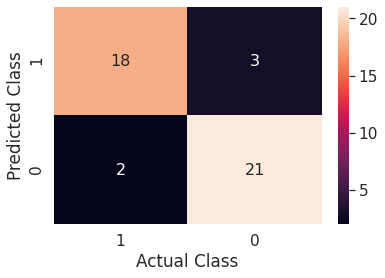

In [ ]:
x_axis_labels = [1,0]
y_axis_labels = [1,0]

sns.set(font_scale=1.4)
sns.heatmap(tuned_xgb_cm1, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, annot_kws = {'size': 16})
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

Definitely this is biased towards, postive class. Since this is unbalanced dataset. We will hyeprtune with equally balanced dataset

### Hypertuning for balanced dataset

In [ ]:
tuned_xgb2 = XGBClassifier()

In [ ]:
random_search2 = RandomizedSearchCV(tuned_xgb2, param_distributions = params, n_iter = 5, scoring = 'roc_auc', n_jobs = 1, cv = 5, verbose = 3)

In [ ]:
random_search2.fit(fs_Xtrain, fs_ytrain)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[05:05:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.1, max_depth=4, min_child_weight=7; total time=   0.0s
[05:05:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.1, max_depth=4, min_child_weight=7; total time=   0.0s
[05:05:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=No

In [ ]:
random_search2.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
random_search2.best_params_

{'min_child_weight': 1,
 'max_depth': 10,
 'learning_rate': 0.25,
 'gamma': 0.3,
 'colsample_bytree': 0.7}

In [ ]:
tuned_score2 = random_search2.score(fs_Xtest, fs_ytest)
print(tuned_score2)

0.9585921325051759


In [ ]:
print (f'Train Accuracy - : {random_search2.score(fs_Xtrain,fs_ytrain):.3f}')
print (f'Test Accuracy - : {random_search2.score(fs_Xtest,fs_ytest):.3f}')

Train Accuracy - : 1.000
Test Accuracy - : 0.959


In [ ]:
tuned_xgb_pred2 = random_search2.predict(fs_Xtest)
tuned_xgb_cm2 = confusion_matrix(fs_ytest, tuned_xgb_pred2, labels = [1,0])
print("Confusion Matrix: \n", tuned_xgb_cm2)

Confusion Matrix: 
 [[19  2]
 [ 2 21]]


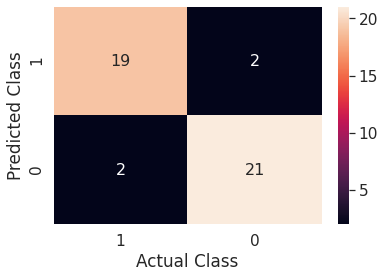

In [ ]:
x_axis_labels = [1,0]
y_axis_labels = [1,0]

sns.set(font_scale=1.4)
sns.heatmap(tuned_xgb_cm2, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, annot_kws = {'size': 16})
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

In [ ]:
model_score = model_score.append(pd.DataFrame({'Original_Dataset': [tuned_score1], 'Selected_Dataset': [tuned_score2]}, index = ['XGBoost']))


In [ ]:
model_score

,Original_Dataset,Selected_Dataset
LogisticRegression,0.704545,0.590909
NaiveBayes,0.522727,0.522727
KNN,0.681818,0.840909
DecisionTrees,0.863636,0.909091
RandomForest,0.909091,0.886364
XGBoost,0.971014,0.958592


As we can see, <b> XGBoost </b> performs best, on <b> selected features </b>.

In [ ]:
## Checking Classification report of the best model

print(classification_report(fs_ytest, tuned_xgb_pred2))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        23
           1       0.90      0.90      0.90        21

    accuracy                           0.91        44
   macro avg       0.91      0.91      0.91        44
weighted avg       0.91      0.91      0.91        44



In [ ]:
## Biased model

print(classification_report(y_test, tuned_xgb_pred1))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89        23
           1       0.90      0.86      0.88        21

    accuracy                           0.89        44
   macro avg       0.89      0.89      0.89        44
weighted avg       0.89      0.89      0.89        44



In [ ]:
### Checking Classification report of the worst model

print(classification_report(y_test, lr_ypred2 ))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72        23
           1       1.00      0.14      0.25        21

    accuracy                           0.59        44
   macro avg       0.78      0.57      0.48        44
weighted avg       0.77      0.59      0.50        44

